Support Vector Machines: what do features in the implicit space mean?
===

I think a lot of SVM tutorials give all the details about the maximum margin separating hyperplane, the quadratic programming and support vectors, and radial kernels, but don't give a good intuition on one important part of the big picture. When the kernel does its implicit mapping from the original feature space to a new feature space, what does that new feature space look like? What do the features in that new space mean? This short notebook tries to fill in the missing link.

In [1]:
import numpy as np, matplotlib.pyplot as plt
%matplotlib inline

Suppose our training data $X$ is in two dimensions and consists of four points with labels -1 (blue) and +1 (red).

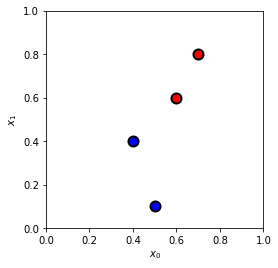

In [2]:
X = np.array([[0.5, 0.1], [0.4, 0.4], [0.6, 0.6], [0.7, 0.8]])
y = np.array([-1, -1, 1, 1])
y_pos = (y == 1)
y_neg = (y == -1)
plt.plot(X[y_neg, 0], X[y_neg, 1], '.', c='b', markersize=20, mew=2, mec='k')
plt.plot(X[y_pos, 0], X[y_pos, 1], '.', c='r', markersize=20, mew=2, mec='k')
plt.xlabel(r"$x_0$")
plt.ylabel(r"$x_1$")
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.axes().set_aspect('equal')

The goal of the SVM is to classify new unknown points, such as the point $q$ indicated by the green square here.

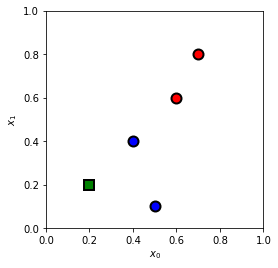

In [3]:
q = np.array([0.2, 0.2])
plt.plot(X[y_neg, 0], X[y_neg, 1], '.', c='b', markersize=20, mew=2, mec='k')
plt.plot(X[y_pos, 0], X[y_pos, 1], '.', c='r', markersize=20, mew=2, mec='k')
plt.plot(q[0], q[1], 's', c='g', markersize=10, mew=2, mec='k')
plt.xlabel(r"$x_0$")
plt.ylabel(r"$x_1$")
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.axes().set_aspect('equal')

We'll use a Gaussian kernel $K_h$ with bandwidth $h$. That means that the value of $K_h(x, y)$ is the value of a 1-dimensional Gaussian centered at $0$ with $\sigma^2=h$, evaluated at the point $|x-y|$, that is the point on the axis which is $|x-y|$ in distance from the centre of the Gaussian. 

A kernel is a *measure of similarity*, so $K$ will be large when $x$ and $y$ are close together.

In [4]:
def d(x, y):
    return np.linalg.norm(x - y) # Euclidean distance

def K(x, y):
    h = 0.5
    return np.exp(- d(x, y) / (2 * h**2.0))

Any point $q$ in the original space will be (implicitly) mapped to a point $z(q)$ in the new space, and that new point will have coordinates given by $K(q, x_i)$, for each of the support vectors $x_i$.

In [5]:
def z(q, SVs):
    return np.array([K(q, xi) for xi in SVs])

Our original training data maps to the new space as follows. For each point in the training data, and each support vector, we calculate $K$ between the training point and the SV, and that gives one feature $z_i$ for that training point. 

Let's suppose that we have exactly two support vectors, that is two of our training points become support vectors. (In a real example, the choice would be made by the quadratic programming training procedure, and there would not just be two.) It's useful to think of the SVs as the points which are closest to the boundary between classes, so we can see that the SVs will be the two points $(0.4, 0.4), (0.6, 0.6)$ -- one labelled -1, the other +1.

In [6]:
SVs = X[1:3]
Z = np.array([z(xi, SVs) for xi in X])
Z

array([[ 0.53128561,  0.36066566],
       [ 1.        ,  0.56797071],
       [ 0.56797071,  1.        ],
       [ 0.36787944,  0.63940732]])

Note the value 1.0, which occurs when evaluating $K(x, x)$, ie the similarity between a point and itself. It's the largest possible similarity.

We can also do the same for our query point $q$ whose label is unknown.

In [7]:
qz = z(q, SVs)
qz

array([ 0.56797071,  0.32259073])

Here, the value approximately 0.57 is a measure of similarity between the green query point and the first SV, that is the upper blue point. This value on $z_0$ is exactly the same as the value which one red point has for $z_0$. Why? Because in the original space, that red point and the green triangle are equally distant from the blue SV.

Now let's look at the implicit new space. In our example, it is of two dimensions, the same as the original space, but that isn't usually the case! The number of dimensions in the new space is equal to the number of SVs. (The reason we created just two SVs is so that the new implicit feature space could be plotted easily.)

The training data and query points are plotted in the new space. We'll plot a good-looking separating hyperplane also, and see that the query point ends up on the "blue" side of it as it should. (In reality, the hyperplane is determined by training, but we won't discuss it.) The hyperplane is indeed a hyperplane here, ie a line and not a curve, because the SVM is a linear classifier in the new implicit space. It may be non-linear when we view the decision function in the original space.

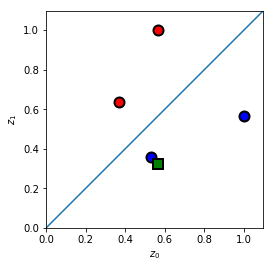

In [8]:
plt.plot(Z[y_neg, 0], Z[y_neg, 1], '.', c='b', markersize=20, mew=2, mec='k')
plt.plot(Z[y_pos, 0], Z[y_pos, 1], '.', c='r', markersize=20, mew=2, mec='k')
plt.plot(qz[0], qz[1], 's', c='g', markersize=10, mew=2, mec='k')
plt.plot((0, 1.1), (0, 1.1))
plt.xlabel(r"$z_0$")
plt.ylabel(r"$z_1$")
plt.xlim((0, 1.1))
plt.ylim((0, 1.1))
plt.axes().set_aspect('equal')

We can *see* the decision for the query point by seeing which side of the line it falls on. But how do we actually calculate the decision? We have a weight $w_i$ for each SV. The line is determined by the $w$. The decision function for a query point $q$ is just $$\sum_i w_i K(q, x_i) > 0$$ where $x_i$ are the SVs: if yes (greater than 0), the output is +1, else -1.

(The real decision function includes a bias $b$: $$\sum_i w_i K(q, x_i) + b > 0$$ but we will ignore that for simplicity.)

We can rewrite the decision function as: if $$\sum_{i: y_i=+1} w_i K(q, x_i) > \sum_{i: y_i=-1} w_i K(q, x_i)$$ then +1, else -1. That is, if the query point is more similar on average to the SVs with label +1 than to the SVs with label -1, then the output is +1 (and vice versa).

The hyperplane, ie the decision boundary, is the set of points at which the two expressions above are equal: $$\sum_{i: y_i=+1} w_i K(q, x_i) = \sum_{i: y_i=-1} w_i K(q, x_i)$$

In our simple example, we'll set the weights $w$ to good values manually: $w = [-1, 1]$ (remember, one weight per SV). That means that similarity to the first SV should give a *negative* contribution to the decision value, leading to a -1 outcome; similarity to the second SV should give a *positive* contribution, leading to a +1 outcome. (In our example we choose good weights by hand, but in reality, the training by QP will give us the weights. We won't discuss the QP in this notebook.)

It's interesting to look at the *decision value* $\sum_i w_i K(q, x_i)$, ie the left-hand side of the decision function, so we'll define that as a separate function.

In [9]:
w = [-1, 1] 

def decision_value(q, SVs):
    wx = np.sum(w[i] * K(q, SVs[i]) for i in range(len(SVs)))
    return wx

def decision_function(q, SVs):
    if decision_value(q, SVs) > 0: return +1
    else                         : return -1

For example, the decision value for $q$ is negative:

In [10]:
decision_value(q, SVs)

-0.24537998230855557

In [11]:
decision_function(q, SVs)

-1

Now, we can plot the decision value over the original space, and superimpose the training data and the query point.

In [12]:
g = 101
grid = np.linspace(0, 1, g)
im = np.zeros((g, g))
for i in range(g):
    for j in range(g):
        im[i, j] = decision_value((grid[i], grid[j]), SVs)

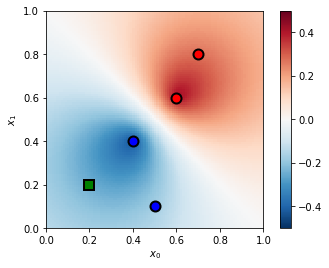

In [13]:
plt.pcolor(grid, grid, im.T, cmap='RdBu_r', vmin=-0.5, vmax=+0.5)
plt.colorbar()
plt.plot(X[y_neg, 0], X[y_neg, 1], '.', c='b', markersize=20, mew=2, mec='k')
plt.plot(X[y_pos, 0], X[y_pos, 1], '.', c='r', markersize=20, mew=2, mec='k')
plt.plot(q[0], q[1], 's', c='g', markersize=10, mew=2, mec='k')
plt.xlabel(r"$x_0$")
plt.ylabel(r"$x_1$")
plt.axes().set_aspect('equal')

Hey, why isn't the decision boundary non-linear as promised? Well, because we only have two SVs. With more SVs, the decision boundary would still be linear in the new (now higher-dimensional) space, but non-linear in the original space. But we can already see non-linear behaviour of the decision *value* plotted above.

But let's add in another training point in such a position that it would become an SV, and see what effect that will have on the decision value and boundary in the original space. (We won't be able to plot it in the new space since it will now have 3 dimensions.) With three SVs, we now need three weights also, and we'll change the values of the weights, again noting that these are not quite realistic. With the three SVs, we now have a non-linear boundary.

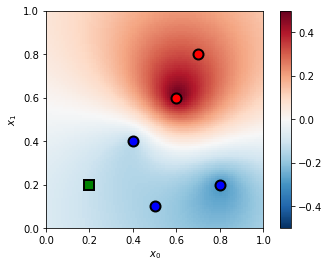

In [14]:
X = np.array([[0.5, 0.1], [0.8, 0.2], [0.4, 0.4], [0.6, 0.6], [0.7, 0.8]])
y = np.array([-1, -1, -1, 1, 1])
y_pos = (y == 1)
y_neg = (y == -1)

SVs = X[1:4]
w = [-0.5, -0.5, 1]

for i in range(g):
    for j in range(g):
        im[i, j] = decision_value((grid[i], grid[j]), SVs)

plt.pcolor(grid, grid, im.T, cmap='RdBu_r', vmin=-0.5, vmax=+0.5)
plt.colorbar()

plt.plot(X[y_neg, 0], X[y_neg, 1], '.', c='b', markersize=20, mew=2, mec='k')
plt.plot(X[y_pos, 0], X[y_pos, 1], '.', c='r', markersize=20, mew=2, mec='k')
plt.plot(q[0], q[1], 's', c='g', markersize=10, mew=2, mec='k')
plt.xlabel(r"$x_0$")
plt.ylabel(r"$x_1$")
plt.axes().set_aspect('equal')

Conclusion
---

So, an SVM can be seen as an algorithm which decides the label of a query point by testing whether it is more similar to a subset (the SVs) of the +1 examples, or to a subset (the SVs) of the -1 examples. Similarity is measured by the kernel, based ultimately on an inverse mapping of Euclidean distance. In this sense, an SVM is closely related to techniques such as $k$ nearest neighbours, kernel density classification, and dissimilarity representations (eg Duin & Pekalska, Pattern Recognition Letters 33 (2012) 826–832). 

In particular, we could make a crude proto-SVM by just calculating the mean of distances (in the original space) from $q$ to all the +1 points, and to all the -1 points, and finding out which is larger! This would leave out the kernel and the choice of SVs, but otherwise would be quite similar to an SVM. We could call it a mean-distance classifier. The computational complexity at query time would scale linearly with the size of the training data, which is a disadvantage relative to an SVM. If we used a kernel instead of just raw distance, it would become a kernel density classifier, with the same computational complexity disadvantage. If we choose a subset of points to be the "prototypes" (the term used in the dissimilarity representation literature), instead of using all training data, the complexity improves. The final refinement would be to define soft constraints that each labelled point be on the right side of the hyperplane, and an objective function which maximises the margin, and optimise using quadratic programming, to find the best prototypes (now called SVs) and weights $w$ -- and then it is an SVM again.

Thanks to Stefano Mauceri and Loi Van Cao for useful discussions on these topics and to Sean McGarraghy for excellent notes in the MIS40530 module.